# OpenVINO™ Explainable AI Toolkit: Saliency map interpretation

<div class="alert alert-block alert-danger"> <b>Important note:</b> This notebook requires python >= 3.10. Please make sure that your environment fulfill to this requirement before running it </div>

**OpenVINO™ Explainable AI (XAI) Toolkit** provides a suite of XAI algorithms for visual explanation of
[**OpenVINO™**](https://github.com/openvinotoolkit/openvino) Intermediate Representation (IR) models.

Using **OpenVINO XAI**, you can generate **saliency maps** that highlight regions of interest in input images from the model's perspective. This helps users understand why complex AI models produce specific responses.

This notebook shows which saliency map are generated in different scenarios, in case of correct and confident prediction, in case of low-confident prediction and in case of mixed up classes. 





#### Table of contents:

- [Prerequisites](#Prerequisites)
    - [Install requirements](#Install-requirements)
    - [Imports](#Imports)
    - [Download dataset](#Download-dataset)
    - [Download IR model](#Download-IR-model)
- [Prepare model to run inference](#Prepare-model-to-run-inference)
    - [Select inference device](#Select-inference-device)
    - [Load the Model](#Load-the-Model)
    - [Define preprocess_fn and postprocess_fn](#Define-preprocess_fn-and-postprocess_fn)
- [Explain](#Explain)
    - [Create explainer](#Create-explainer)
    - [Import ImageNet label names](#Import-ImageNet-label-names)
    - [Explain using ImageNet labels](#Explain-using-ImageNet-labels)
- [Notable usecases in ImageWoof dataset](#Notable-usecases-in-ImageWoof-dataset)
    - [Explain for each usecase](#Explain-for-each-usecase)
    - [Visualize usecase saliency maps](#Visualize-usecase-saliency-maps)
    - [Naming logic](#Naming-logic)
- [Results](#Results)
    - [True Positive High confidence](#True-Positive-High-confidence)
    - [True Positive Low confidence](#True-Positive-Low-confidence)
    - [False Positive High confidence](#False-Positive-High-confidence)
    - [Two mixed predictions](#Two-mixed-predictions)



## Prerequisites
[back to top ⬆️](#Table-of-contents:)

### Install requirements
[back to top ⬆️](#Table-of-contents:)

In [1]:
import platform

# Install openvino package
%pip install -q "openvino>=2024.2.0" opencv-python tqdm
%pip install -q "openvino-xai>=1.0.0"

if platform.system() != "Windows":
    %pip install -q "matplotlib>=3.4"
else:
    %pip install -q "matplotlib>=3.4,<3.7"


[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Imports
[back to top ⬆️](#Table-of-contents:)

In [2]:
import json
import os
import random
import zipfile
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import requests

import openvino.runtime as ov
import openvino_xai as xai
from openvino_xai.explainer import ExplainMode

# Fetch `notebook_utils` module
r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
)

open("notebook_utils.py", "w").write(r.text)

from notebook_utils import download_file

### Download dataset
[back to top ⬆️](#Table-of-contents:)

To see the examples of saliency maps for different usecases, please download the ImageWoof datatet using code below:

In [3]:
base_artifacts_dir = Path("./artifacts").expanduser()
data_folder = base_artifacts_dir / ".data"

In [4]:
# Download 330 MB of 320 px ImageNet subset with dogs breeds

if not (data_folder / "imagewoof320").exists():
    download_file(
    "https://ultralytics.com/assets/imagewoof320.zip",
    directory=data_folder,
    )

    # Define the path to the zip file and the destination directory
    zip_path = data_folder / "imagewoof320.zip"
    extract_dir = data_folder / "imagewoof320"
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

else:
    print(f"Dataset is already downloaded to {base_artifacts_dir} and extracted.")

image_folder_path = data_folder / "imagewoof320" / "imagewoof320"

artifacts/.data/imagewoof320.zip:   0%|          | 0.00/319M [00:00<?, ?B/s]

In [ ]:
# Create list of images
img_data_formats = (".jpg", ".jpeg", ".JPEG", ".gif", ".bmp", ".tif", ".tiff", ".png")

img_files = []
output = Path("saliency_map/imagewoof320")

for format_ in img_data_formats:
    img_files.extend(image_folder_path.rglob(f"*{format_}"))

print(f"Number of images to get explanations: {len(img_files)}")

# Get a fewer subset for fast execution
random.seed(42)
img_files = random.sample(img_files, 3)
print(f"Run explanations on fewer number of images: {len(img_files)}")

Number of images to get explanations: 12954
Run explanations on fewer number of images: 3


### Download IR model
[back to top ⬆️](#Table-of-contents:)


In this notebook for demonstration purposes we'll use an already converted to IR model from OpenVINO storage. 

In [ ]:
model_name = "mobilenetv3_large_100.ra_in1k"
model_xml_name = f"{model_name}.xml"
model_bin_name = f"{model_name}.bin"

model_xml_path = base_artifacts_dir / model_xml_name

base_url = "https://storage.openvinotoolkit.org/repositories/openvino_training_extensions/models/custom_image_classification/"

if not model_xml_path.exists():
    download_file(base_url + model_xml_name, model_xml_name, base_artifacts_dir)
    download_file(base_url + model_bin_name, model_bin_name, base_artifacts_dir)
else:
    print(f"{model_name} already downloaded to {base_artifacts_dir}")

mobilenetv3_large_100.ra_in1k already downloaded to artifacts


## Prepare model to run inference
[back to top ⬆️](#Table-of-contents:)

### Select inference device
[back to top ⬆️](#Table-of-contents:)

select device from dropdown list for running inference using OpenVINO

In [ ]:
import ipywidgets as widgets

core = ov.Core()
device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value="AUTO",
    description="Device:",
    disabled=False,
)

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

### Load the Model
[back to top ⬆️](#Table-of-contents:)


In [ ]:
core = ov.Core()
model = core.read_model(model=model_xml_path)
compiled_model = core.compile_model(model=model, device_name=device.value)

### Define preprocess_fn and postprocess_fn
[back to top ⬆️](#Table-of-contents:)

To run model inference, you need to define functions to preprocess data and postprocess the results based on the model's implementation. Since the used model is originally from [timm storage](https://github.com/huggingface/pytorch-image-models), we need to apply specific timm preprocessing, including normalization and scaling with certain values.

In [ ]:
def preprocess_fn(x: np.ndarray) -> np.ndarray:
    mean = np.array([123.675, 116.28, 103.53])
    std = np.array([58.395, 57.12, 57.375])

    # Implementing own pre-process function based on model's implementation
    x = cv2.resize(src=x, dsize=(224, 224))
    # Normalization and scaling for timm model
    x = (x - std) / mean

    # Reshape to model input shape to [channels, height, width].
    x = x.transpose((2, 0, 1))
    # Add batch dimension
    x = np.expand_dims(x, 0)
    return x

def postprocess_fn(x: np.ndarray) -> np.ndarray:
    # Process model prediction
    prediction_processed = softmax(x)
    return prediction_processed


def softmax(x):
    """Compute softmax values of x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


## Explain
[back to top ⬆️](#Table-of-contents:)


### Create explainer 
[back to top ⬆️](#Table-of-contents:)

The `explainer` can internally apply pre-processing during model inference, allowing raw images as input.

To enable this, define `preprocess_fn` and provide it to the explainer constructor. In case where we pass multiple unprocessed images, as done in this notebook, we need to define `preprocess_fn`. 

If it's not defined, it's assumed that the input is preprocessed.

In [ ]:
# Create ov.Model
model = ov.Core().read_model(model_xml_path)

# Create explainer object
explainer = xai.Explainer(
    model=model,
    task=xai.Task.CLASSIFICATION,
    preprocess_fn=preprocess_fn,
    explain_mode=ExplainMode.WHITEBOX,
)

INFO:openvino_xai:Target insertion layer is not provided - trying to find it in auto mode.
INFO:openvino_xai:Using ReciproCAM method (for CNNs).
INFO:openvino_xai:Explaining the model in white-box mode.


### Import ImageNet label names 
[back to top ⬆️](#Table-of-contents:)

If model doesn't have a label list in meta information, the saved saliency map will have the predicted class index, not name. For example,  `n02089973_3688_target_167.jpg` instead of `n02089973_3688_target_English_foxhound.jpg`. 

To conveniently view label names in saliency maps, you can include ImageNet label list information in the explanation parameters.

In [ ]:
imagenet_filename = download_file(
    "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/datasets/imagenet/imagenet_2012.txt",
    directory=".data",
)

imagenet_classes = imagenet_filename.read_text().splitlines()

'.data/imagenet_2012.txt' already exists.


In [ ]:
# Get ImageNet label list to add them to explanations

imagenet_labels = []
for label in imagenet_classes:
    class_label = " ".join(label.split(" ")[1:])
    first_class_label = class_label.split(",")[0].replace(" ", "_")
    imagenet_labels.append(first_class_label)

print(" ".join(imagenet_labels[:10]))

tench goldfish great_white_shark tiger_shark hammerhead electric_ray stingray cock hen ostrich


### Explain using ImageNet labels
[back to top ⬆️](#Table-of-contents:)

In [ ]:
output = base_artifacts_dir / "saliency_maps" / "multiple_images"

# Explain model and save results using ImageNet label names
for image_path in img_files:
    image = cv2.imread(str(image_path))
    explanation = explainer(
        image,
        targets=["flat-coated_retriever", "Samoyed"],  # Also label indexes [206, 258] are possible as target
        label_names=imagenet_labels,
    )
    explanation.save(output, Path(image_path).stem)

Below in `base_artifacts_dir / "saliency_maps" / "multiple_images"` you can see saved saliency maps:

In [ ]:
# See saliency that was saved in `output` with predicted label in image name
for file_name in output.glob("*"):
    print(file_name)

artifacts/saliency_maps/multiple_images/n02096294_6183_target_flat-coated_retriever.jpg
artifacts/saliency_maps/multiple_images/n02096294_6183_target_microwave.jpg
artifacts/saliency_maps/multiple_images/n02105641_2491_target_microwave.jpg
artifacts/saliency_maps/multiple_images/n02105641_2491_target_flat-coated_retriever.jpg
artifacts/saliency_maps/multiple_images/n02093754_1845_target_microwave.jpg
artifacts/saliency_maps/multiple_images/n02093754_1845_target_flat-coated_retriever.jpg


## Notable usecases in ImageWoof dataset
[back to top ⬆️](#Table-of-contents:)


Below a few examples were chosen to show cases, when:
- The correct class was predicted with the high confidence (`True Positive, high confidence`)
- The correct class was predicted, but with the low confidence for some reason (`True Positive, low confidence`)
- The predicted class has a high confidence, but was incorrect, one class was treated as the other one (`False positive, high confidence`)
- Two classes were predicted with rather same high confidence with the different saliency maps for each of them (`Two predictions`)

The `imagewoof_usecases.json` contains paths to images with those respective use cases:

In [ ]:
# Read file with paths to noticable usecases
with open("imagewoof_usecases.json", "r") as f:
    usecases_image_paths = json.load(f)

# Add mapping from folder to label, label_idx to define the ground-truth label, label_idx from name
label_mapping = {
    "n02088364": ("beagle", 162),
    "n02099601": ["golden retriever", 207],
    "n02105641": ["Old English sheepdog", 229],
    "n02111889": ["Samoyed", 258],
    "n02086240": ["Shih-Tzu", 155],
    "n02089973": ["English foxhound", 167],
    "n02087394": ["Rhodesian ridgeback", 159],
    "n02096294": ["Australian terrier", 193],
    "n02115641": ["dingo", 273],
}

In [ ]:
def get_model_predictions(conf_thr=0.1):
    # Run model inference
    result_infer = compiled_model([preprocess_fn(image)])[0]
    result_infer = postprocess_fn(result_infer)[0]
    result_idxs = np.argwhere(result_infer>conf_thr).flatten()
    result_scores = result_infer[result_idxs]

    for index, score in zip(result_idxs, result_scores):
        print(
            f"Predicted class {imagenet_labels[index]}, index {index}, probability: {score:.2f}"
        )

    return result_infer, result_idxs, result_scores

### Explain for each usecase
[back to top ⬆️](#Table-of-contents:)

In [ ]:
output = base_artifacts_dir / "saliency_maps" / "imagewoof320"

# Run explanation for chosen paths
for usecase in usecases_image_paths:
    os.makedirs(output / usecase, exist_ok=True)
    image_paths = usecases_image_paths[usecase]["paths"]
    usecase_conf_thr = usecases_image_paths[usecase]["confidence"]

    for image_path in image_paths:
        image = cv2.imread(str(image_folder_path / image_path))
        image_name = Path(image_path).stem

        folder_name = image_name.split("_")[0]
        gt_class, gt_class_idx = label_mapping[folder_name]

        scores, result_idxs, result_scores = get_model_predictions(usecase_conf_thr)
        gt_conf = scores[gt_class_idx]
        gt_info = f"gt_{gt_conf:.2f}_{gt_class}"

        explanation = explainer(
            image,
            targets=result_idxs, # Return saliency maps for predicted classes
            label_names=imagenet_labels,
            overlay = True
        )

        # Save saliency maps, use detailed implementation instead of explanation.save
        # to return predicted scores
        for score in result_scores:
            for cls_idx, map_to_save in explanation.saliency_map.items():
                target_name = imagenet_labels[cls_idx]
                cv2.imwrite(
                    os.path.join(output / usecase, f"{image_name}_{gt_info}_pr_{score:.2f}_{target_name}.jpg"), 
                    img=map_to_save
                )

Predicted class beagle, index 162, probability: 0.97
Predicted class golden_retriever, index 207, probability: 0.88
Predicted class Old_English_sheepdog, index 229, probability: 0.96
Predicted class Samoyed, index 258, probability: 0.94
Predicted class Shih-Tzu, index 155, probability: 0.18
Predicted class Shih-Tzu, index 155, probability: 0.18
Predicted class Shih-Tzu, index 155, probability: 0.20
Predicted class golden_retriever, index 207, probability: 0.18
Predicted class dalmatian, index 251, probability: 0.98
Predicted class bannister, index 421, probability: 0.78
Predicted class car_mirror, index 475, probability: 0.82
Predicted class quilt, index 750, probability: 0.80
Predicted class bubble, index 971, probability: 0.79
Predicted class dogsled, index 537, probability: 0.79
Predicted class Arctic_fox, index 279, probability: 0.95
Predicted class Chihuahua, index 151, probability: 0.93
Predicted class golden_retriever, index 207, probability: 0.30
Predicted class Labrador_retrie

In [ ]:
# Check saved saliency maps fore debugging purposes
for usecase in usecases_image_paths:
    print(usecase)
    for file_name in (output / usecase).glob("*"):
        print(file_name)

tp_high_conf
artifacts/saliency_maps/imagewoof320/tp_high_conf/n02111889_17737_gt_0.94_Samoyed_pr_0.94_Samoyed.jpg
artifacts/saliency_maps/imagewoof320/tp_high_conf/n02105641_817_gt_0.96_Old English sheepdog_pr_0.96_Old_English_sheepdog.jpg
artifacts/saliency_maps/imagewoof320/tp_high_conf/n02099601_6505_gt_0.88_golden retriever_pr_0.88_golden_retriever.jpg
artifacts/saliency_maps/imagewoof320/tp_high_conf/n02088364_2019_gt_0.97_beagle_pr_0.97_beagle.jpg
tp_low_conf
artifacts/saliency_maps/imagewoof320/tp_low_conf/n02086240_1765_gt_0.18_Shih-Tzu_pr_0.18_Shih-Tzu.jpg
artifacts/saliency_maps/imagewoof320/tp_low_conf/n02099601_7942_gt_0.18_golden retriever_pr_0.18_golden_retriever.jpg
artifacts/saliency_maps/imagewoof320/tp_low_conf/n02086240_3709_gt_0.20_Shih-Tzu_pr_0.20_Shih-Tzu.jpg
artifacts/saliency_maps/imagewoof320/tp_low_conf/n02086240_1422_gt_0.18_Shih-Tzu_pr_0.18_Shih-Tzu.jpg
fp_high_conf
artifacts/saliency_maps/imagewoof320/fp_high_conf/n02096294_2323_gt_0.00_Australian terrier_

### Visualize usecase saliency maps
[back to top ⬆️](#Table-of-contents:)

The function below helps to visualise the results, creating the matrix of pictures, its names and the confidence of predictions:

In [ ]:
# Function to show result images for each usecase
def show_usecase_image(usecase):
    usecase_output_dir = output / usecase

    image_paths = sorted(os.listdir(usecase_output_dir))
    number_images = len(image_paths)

    fig, axs = plt.subplots((number_images + 1) // 2, 2, figsize=(10, 10))
    fig.tight_layout()
    fig.suptitle(usecase)
    fig.subplots_adjust(top=0.88)
    axs = axs.flatten()

    for image_path, ax in zip(image_paths, axs):
        image_sal_map = cv2.imread(f"{usecase_output_dir}/{image_path}")
        # image_sal_map = cv2.cvtColor(image_sal_map, cv2.COLOR_BGR2RGB)

        image_name = Path(image_path).stem
        image_name = image_name.replace("_target", "")
        image_name = "_".join(image_name.split("_")[1:])

        ax.imshow(image_sal_map)
        ax.set_title(f"{image_name}", wrap=True)
        ax.axis("off")

    if number_images % 2 == 1:
        axs[-1].set_visible(False)

    plt.show()

See the list of usecase names:

In [ ]:
print(f"Names of usecases: {list(usecases_image_paths.keys())}")

Names of usecases: ['tp_high_conf', 'tp_low_conf', 'fp_high_conf', 'tp_two_preds']


### Naming logic
[back to top ⬆️](#Table-of-contents:)

The name of saved saliency maps in this notebook contains info about ground-thruth class, predicted class and its confidence. For better understanding, let's split the name onto meaningful parts and learn its meaning, taking `n02115641_5752_gt_dingo_0.18_target_Chihuahua_0.93` as an example.

`n02115641_5752` - the original name of the image.

`gt_dingo_0.18` - `ground-truth` info, the image was annotated as `dingo` class and model predicted this class with `0.18` confidence.

`target_Chihuahua_0.93` - `predicted` info, the winning class is `Chihuahua` and the model made this prediction with `0.93` confidence.


## Results
[back to top ⬆️](#Table-of-contents:)

### True Positive High confidence
[back to top ⬆️](#Table-of-contents:)

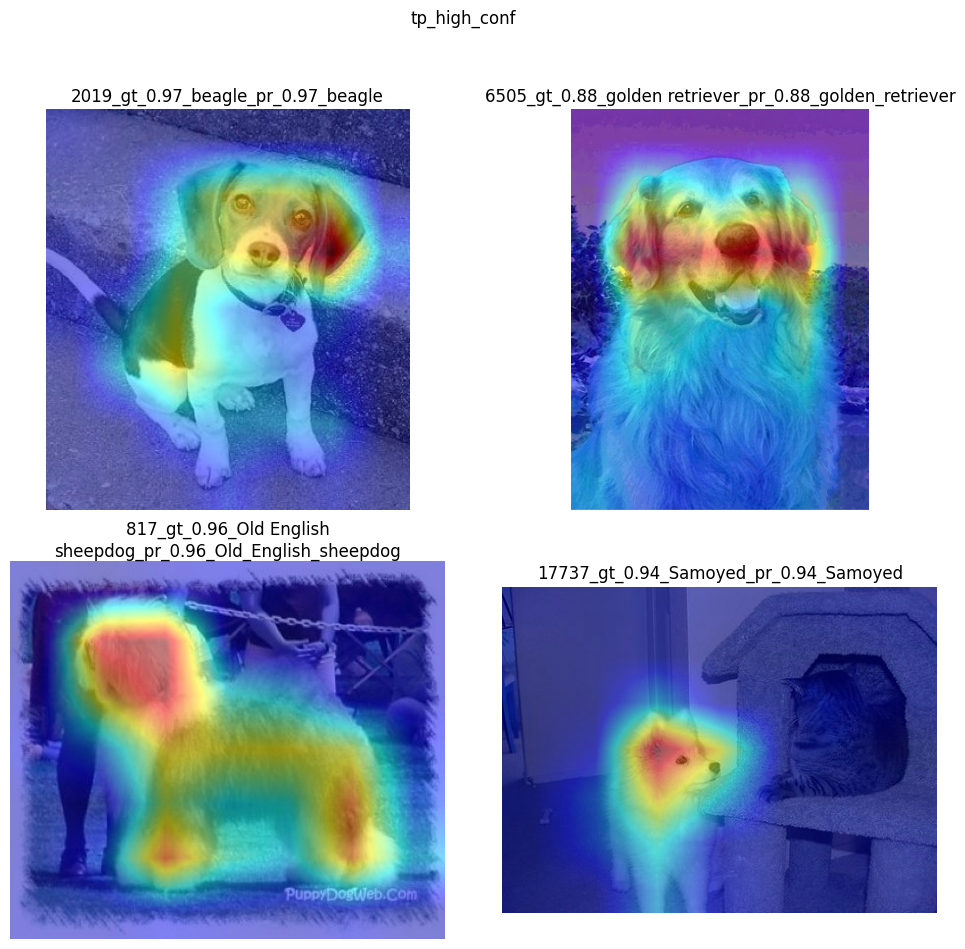

In [ ]:
show_usecase_image("tp_high_conf")

In these cases of `True positive high confidence` the saliency maps are considered to be canonical. 

The areas of attention are focused around the ground truth object highlighting the most important features to udentify the class like face shape, nose and ears and also the general shape of the dog. 

Another sign that predicted saliency map are high-quality is that classes are separate enough, meaning that it doesn't highlight objects of the other classes, like the `cat` class on the 3th image.

### True Positive Low confidence
[back to top ⬆️](#Table-of-contents:)

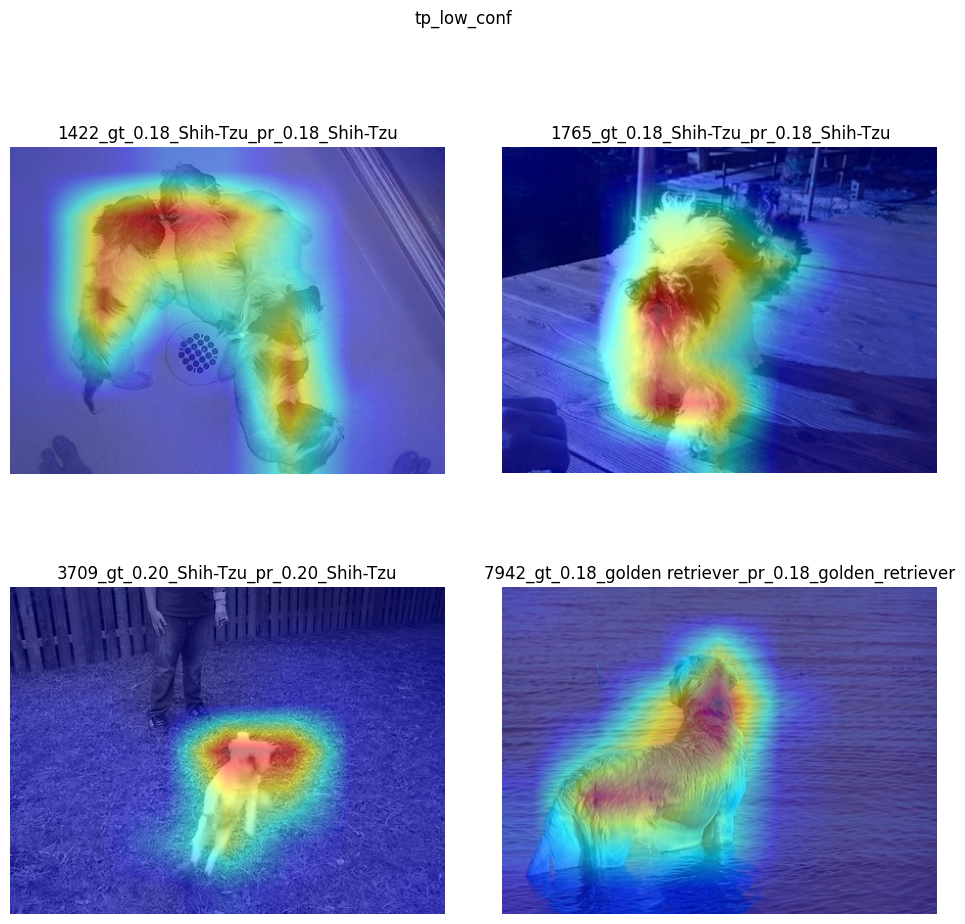

In [ ]:
show_usecase_image("tp_low_conf")

If objects are not focused enough or needed features aren't seen, the `confidence` is decreasing. The model's attention highlight the whole object, trying to make  a decision based on high level features. It makes the prediction confidence lower and in case of high `confidence treshold`, such predictions can be filtered out.

### False Positive High confidence
[back to top ⬆️](#Table-of-contents:)


In [ ]:
show_usecase_image("fp_high_conf")

FileNotFoundError: [Errno 2] No such file or directory: 'artifacts/saliency_maps/imagewoof320/fp_high_conf'

Here we see a few different reasons why model can one class instead of another:

- There are objects of 2 classes represented on the image and one of the class is much more obvious than another. For example, it's larger or on the foreground.
We can see it on the 1st image (`bannister` instead of `beagle`), 2nd (`dogsled` instead of `samoyed`), 3rd (`quilt` instead of `Australian terrier`), 4th (`car mirror` instead of `beagle`).
<!-- We can see it on the 2nd image (`bubbles` are predicted instead of `golden retreiver`), 3rd (`bassinet` instead of `beagle`), 4th (`carr mirror` instead of `beagle`), 5th (`blanket` instead of `terrier`), 6th (`dogsled` instead of `samoyed`). -->

We can see that it's not the problem of the model but rather the characteristic of the picture itself.

- Two classes looks similar in the specific shooting settings.

On the 5th picture sleeping `samoyed` was confused with `arctic fox` because the sleeping position distorted the key features, so classes look even more alike then usual.

<!-- On the 1st picture the big `dingo` dog was confused with small `chihuahua` focusing only on the face features. On the 7th picture sleeping `samoyed` was confused with `arctic fox` because the sleeping position distorted the key features, so classes look even more alike then usual. On the 8th picture shadows created a pattern on the dog, so model found key features for `dalmatian` class and predicted it with the high confidence. -->

Here we see that model is well-trained and mixes classes only because of intricate shooting conditions and presence of more than 1 class on the picture.

### Two mixed predictions
[back to top ⬆️](#Table-of-contents:)


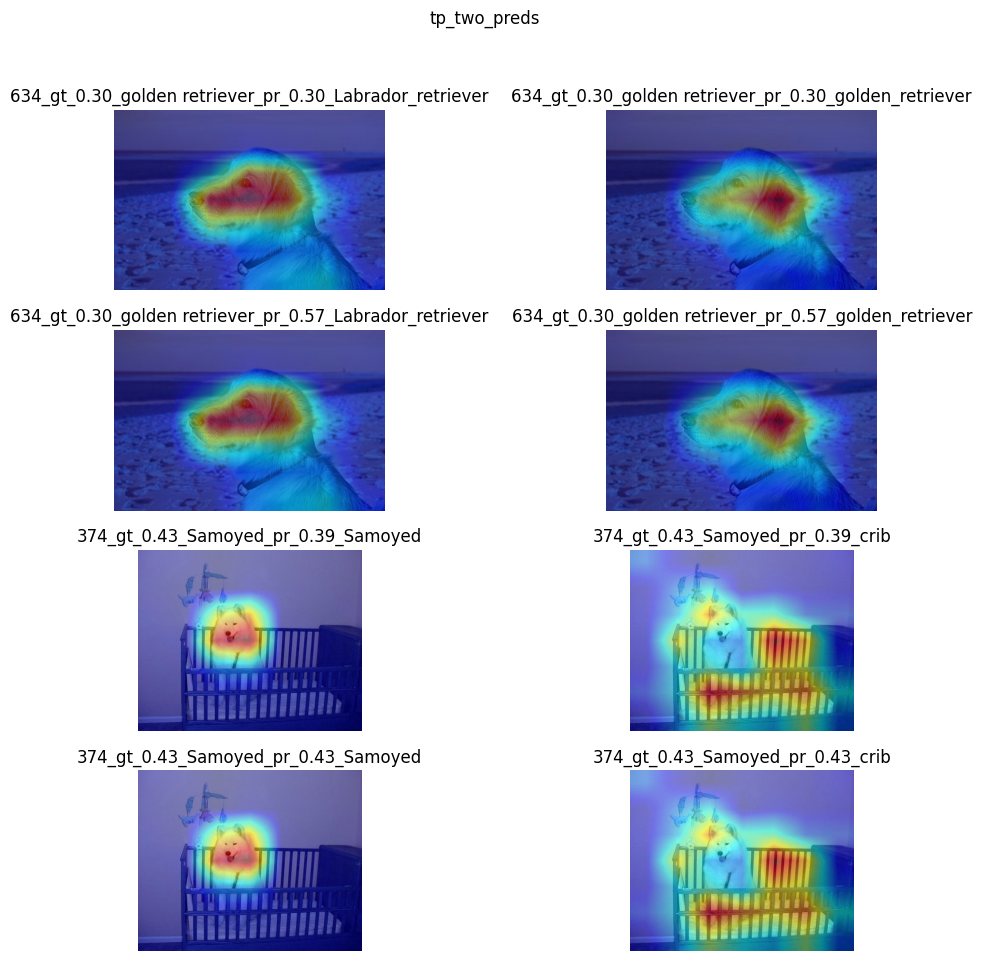

In [ ]:
show_usecase_image("tp_two_preds")

Here are the examples where two classes are predicted with relatively high confidence and model is sure about both of them. We can see how saliency maps are different for each class.

On the 2nd-3th image both `samoyed` and `crib` are well-seen, so model cannot decide between these 2 classes. We clearly see the different areas of interest for each of these classes.

On the 1st-2nd picture model can't decide between `golden retreiver` and `labrador` focusing on the whole face shape.